In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from PIL import Image

DATA_ROOT = "../mvtec_anomaly_detection"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
products = sorted([
    d for d in os.listdir(DATA_ROOT)
    if os.path.isdir(os.path.join(DATA_ROOT, d))
])
print("Products:", products)


Products: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [3]:
# ---------- Dataset ----------
class MVTecDataset(Dataset):
    def __init__(self, root, product, split="train"):
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        base = os.path.join(root, product, split)

        if split == "train":
            img_dir = os.path.join(base, "good")
            for f in os.listdir(img_dir):
                self.samples.append((os.path.join(img_dir, f), 0))
        else:
            for cls in os.listdir(base):
                label = 0 if cls == "good" else 1
                img_dir = os.path.join(base, cls)
                for f in os.listdir(img_dir):
                    self.samples.append((os.path.join(img_dir, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), label


# ---------- Model ----------
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-2])

    def forward(self, x):
        f = self.features(x)
        return f.mean(dim=[2, 3])  # Global Average Pooling


# ---------- Feature Extraction ----------
def extract_features(model, loader, device):
    model.eval()
    feats = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            f = model(x)
            feats.append(f.cpu())
            labels.extend(y.numpy())

    return torch.cat(feats, dim=0), np.array(labels)


In [4]:
def evaluate_product(model, product):
    train_ds = MVTecDataset(DATA_ROOT, product, "train")
    test_ds  = MVTecDataset(DATA_ROOT, product, "test")

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

    train_feats, _ = extract_features(model, train_loader, DEVICE)
    test_feats, test_labels = extract_features(model, test_loader, DEVICE)

    scores = []
    for f in test_feats:
        dist = torch.cdist(f.unsqueeze(0), train_feats)
        scores.append(dist.min().item())

    return roc_auc_score(test_labels, scores)


In [5]:
model = FeatureExtractor().to(DEVICE)
model.eval()

results = {}

for p in products:
    auc = evaluate_product(model, p)
    results[p] = auc
    print(f"{p:12s} AUROC: {auc:.4f}")


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


bottle       AUROC: 0.9937
cable        AUROC: 0.8774
capsule      AUROC: 0.8632
carpet       AUROC: 0.7705
grid         AUROC: 0.4754
hazelnut     AUROC: 0.9696
leather      AUROC: 0.8855
metal_nut    AUROC: 0.8265
pill         AUROC: 0.7526
screw        AUROC: 0.7739
tile         AUROC: 0.9737
toothbrush   AUROC: 0.9389
transistor   AUROC: 0.9125
wood         AUROC: 0.8904
zipper       AUROC: 0.9417


In [6]:
mean_auc = np.mean(list(results.values()))
print("Mean AUROC:", mean_auc)


Mean AUROC: 0.856358753551198


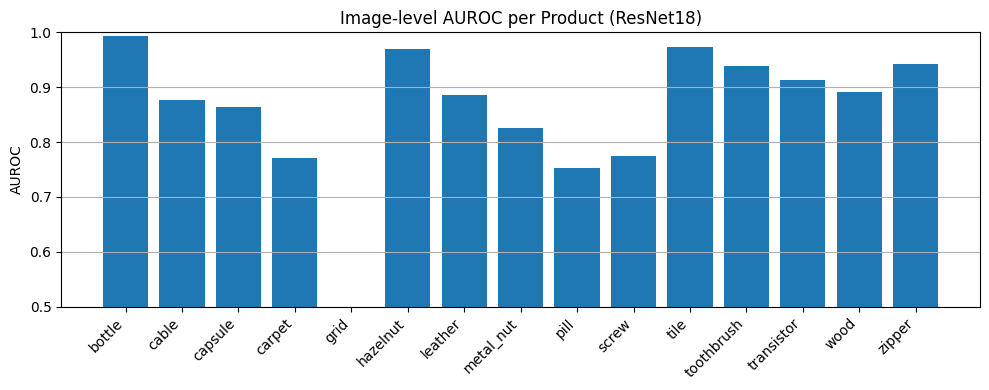

In [7]:
# Cell X: Visualization of AUROC results

import matplotlib.pyplot as plt

products = list(results.keys())
aurocs = list(results.values())

plt.figure(figsize=(10, 4))
plt.bar(products, aurocs)
plt.xticks(rotation=45, ha="right")
plt.ylabel("AUROC")
plt.title("Image-level AUROC per Product (ResNet18)")
plt.ylim(0.5, 1.0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


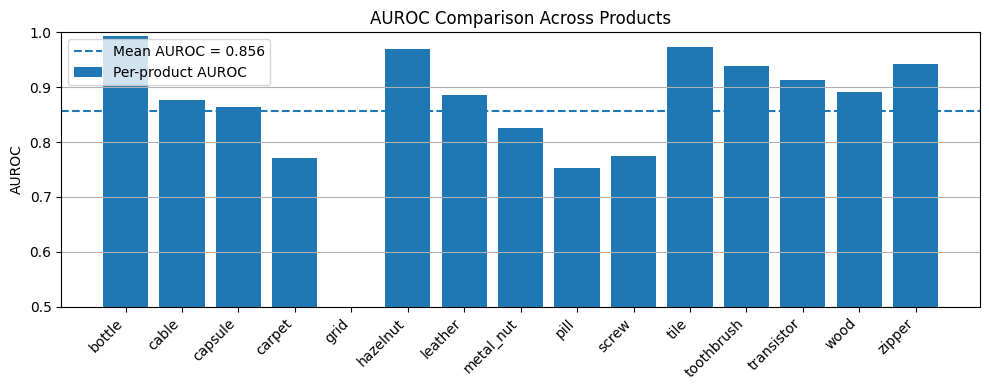

In [8]:
mean_auc = np.mean(aurocs)

plt.figure(figsize=(10, 4))
plt.bar(products, aurocs, label="Per-product AUROC")
plt.axhline(mean_auc, linestyle="--", label=f"Mean AUROC = {mean_auc:.3f}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("AUROC")
plt.title("AUROC Comparison Across Products")
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()
